In [1]:
import astropy.units as u

from generate_priors_TOI import grab_all_priors
from RV_mini_pipeline import remake_rvfile
from generate_supporting_files import *
import sys
sys.path.insert(0, '/Users/jack/Research/pipelines/exofast_tools/scripts/lightcurve_pipeline/')
from lightcurve_pipeline import create_light_curve
import pandas as pd
import lightkurve as lk

## System parameters

In [20]:
toi = '6714'
ticid = '261264800'
rv_instrument = 'tres'
outpath = f'/Users/jack/Research/work_for_collabs/'

## Generating priors and SED
Before running this cell, create a directory to store the fit files and generate the prior and SED files using mkticsed. This cell will generate a separate text file containing the relevant priors and starting points. Append this to the end of the prior file generated by mkticsed, deleting the existing metallicity prior. After generating the lightcurves (below), go back and copy the dilution prior for all TESS lightcurve indices.

In [18]:
with open('tres_password.txt', 'r') as file:
    password = file.read().replace('\n', '')

tess_lcs = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0] # booleans for whether or not each lightcurve is from TESS
grab_all_priors(f'TOI-{toi}', tess_lcs=tess_lcs, outpath=outpath, feh_source=None, tres_username='schulte', tres_password=password)

Starting points:
Tc = 2458326.238234
Period = 4.76744210907332
Rp/Rs = 0.06999015545493187
Dilution prior: 0.0 +/- 0.0041319


## Downloading and formatting RVs
Ensure that the units and output filename are correct for the given instrument. Usually, CHIRON RVs are in km/s and TRES RVs are in m/s

In [3]:
path = outpath + f'toi{toi}.spctable'

with open('tres_password.txt', 'r') as file:
    password = file.read().replace('\n', '')

remake_rvfile(path, u.m/u.s, output_filename=outpath+f'{ticid}.TRES.rv', download_rvs=True, username='schulte', password=password, ticid=ticid, instrument=rv_instrument, verbose=False)

## Downloading TESS lightcurves
Run the first cell to see what lightcurves are available, and then modify and run the next cell to download the selected lightcurve. Make sure that you are downloading the highest cadence lightcurves available and that the data are of good quality.

After running the initial EXOFAST fit, you can check for a secondary eclipse by re-running these cells with the correct parameters.

In [3]:
lk.search_lightcurve(f'TIC {ticid}', author='SPOC')

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 01,2018,SPOC,120,261264800,0.0
1,TESS Sector 04,2018,SPOC,120,261264800,0.0
2,TESS Sector 11,2019,SPOC,120,261264800,0.0
3,TESS Sector 12,2019,SPOC,120,261264800,0.0
4,TESS Sector 13,2019,SPOC,120,261264800,0.0
5,TESS Sector 27,2020,SPOC,120,261264800,0.0
6,TESS Sector 28,2020,SPOC,120,261264800,0.0
7,TESS Sector 31,2020,SPOC,120,261264800,0.0
8,TESS Sector 34,2021,SPOC,120,261264800,0.0


Sector: 67. Exposure time: 20 seconds.
period:  4.76744210907332 duration:  1.32103099754484 h tc:  2458326.238234
per-point error value 0.05531859088405373
Transith depth: 0.004899, RMS: 0.0561, Depth/RMS: 0.087


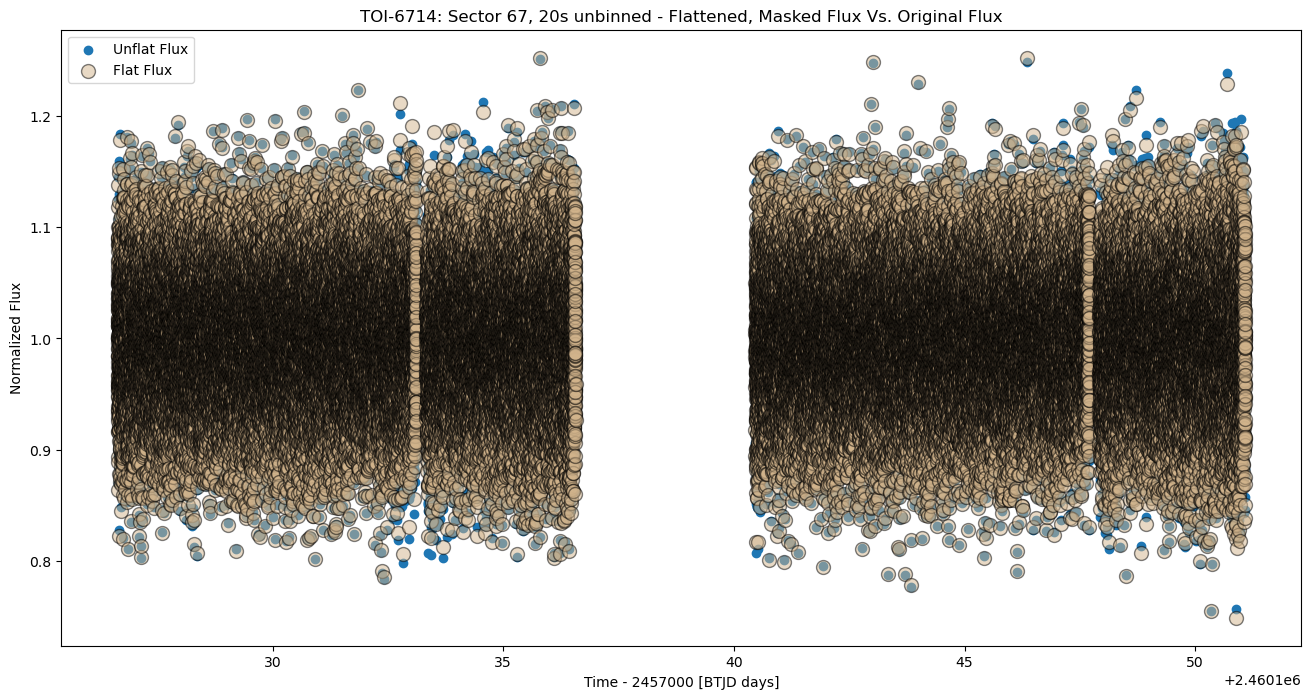

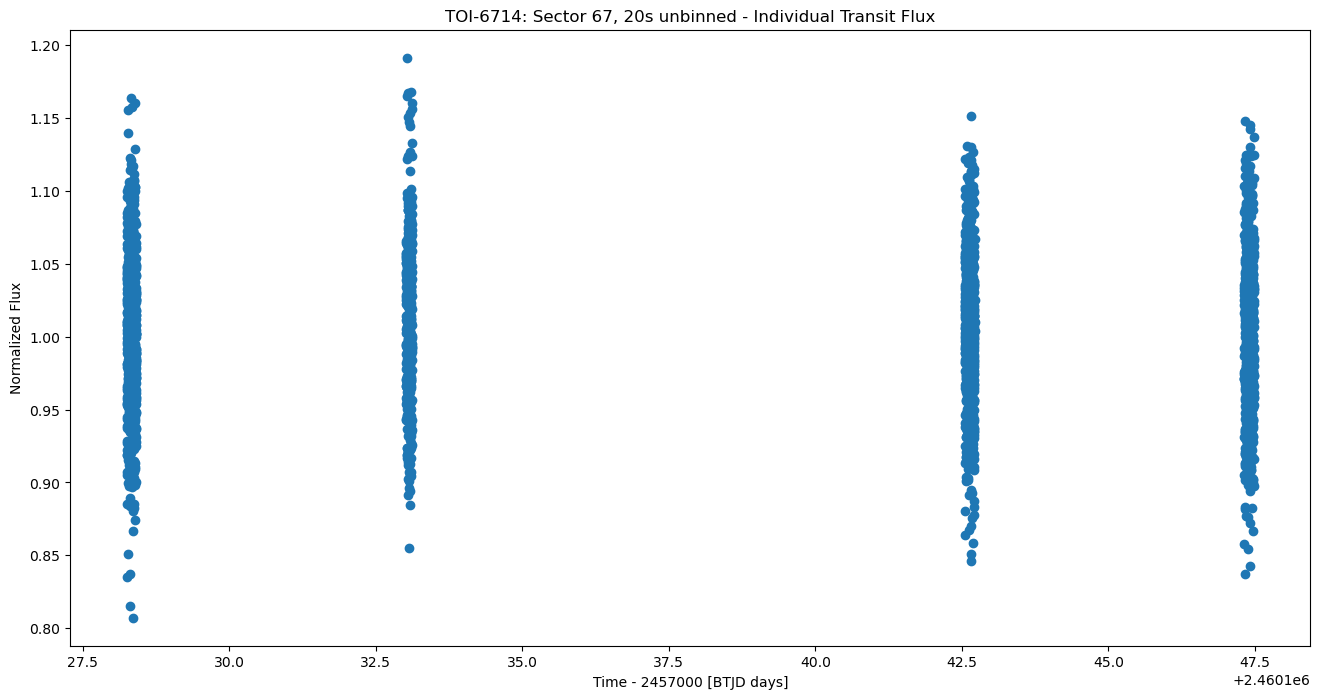

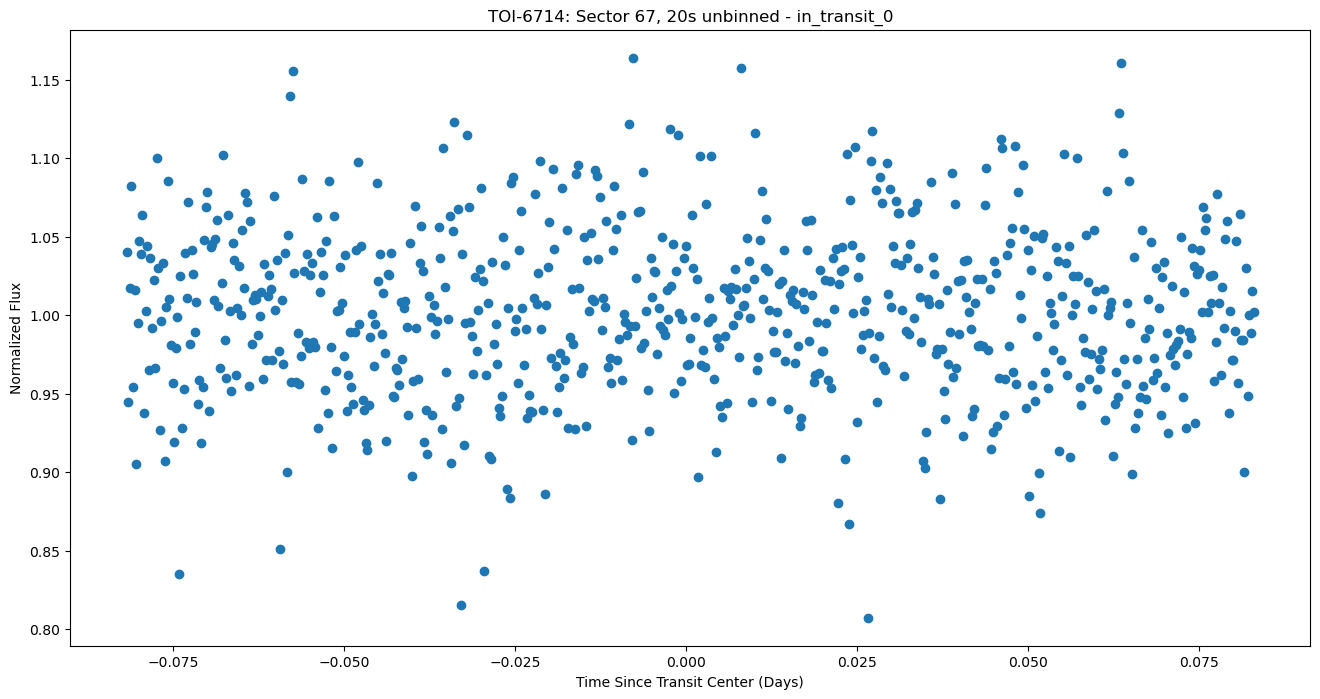

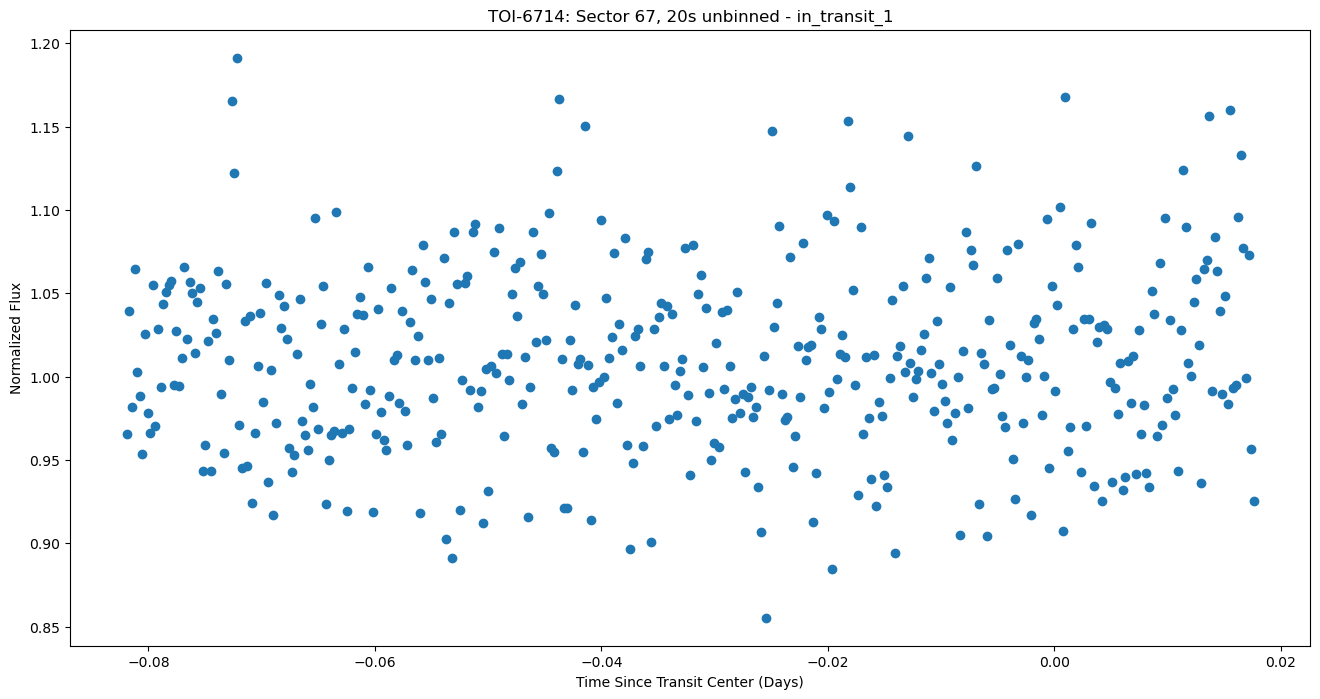

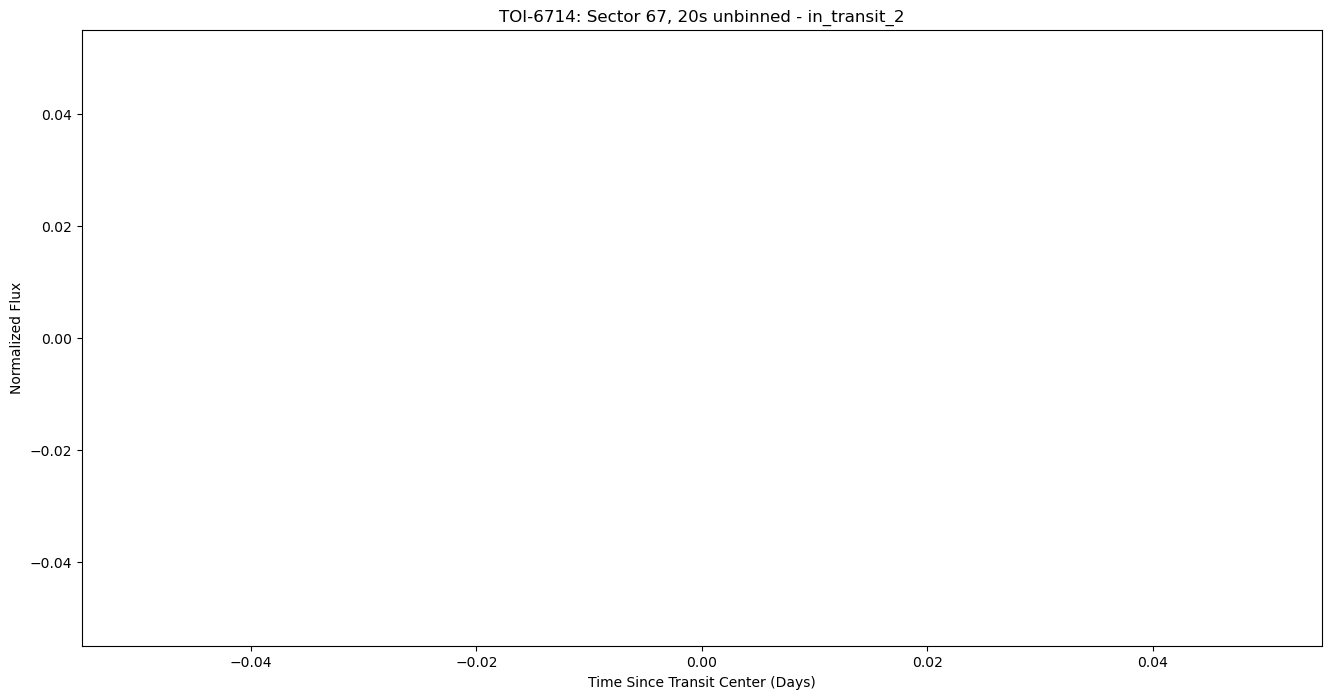

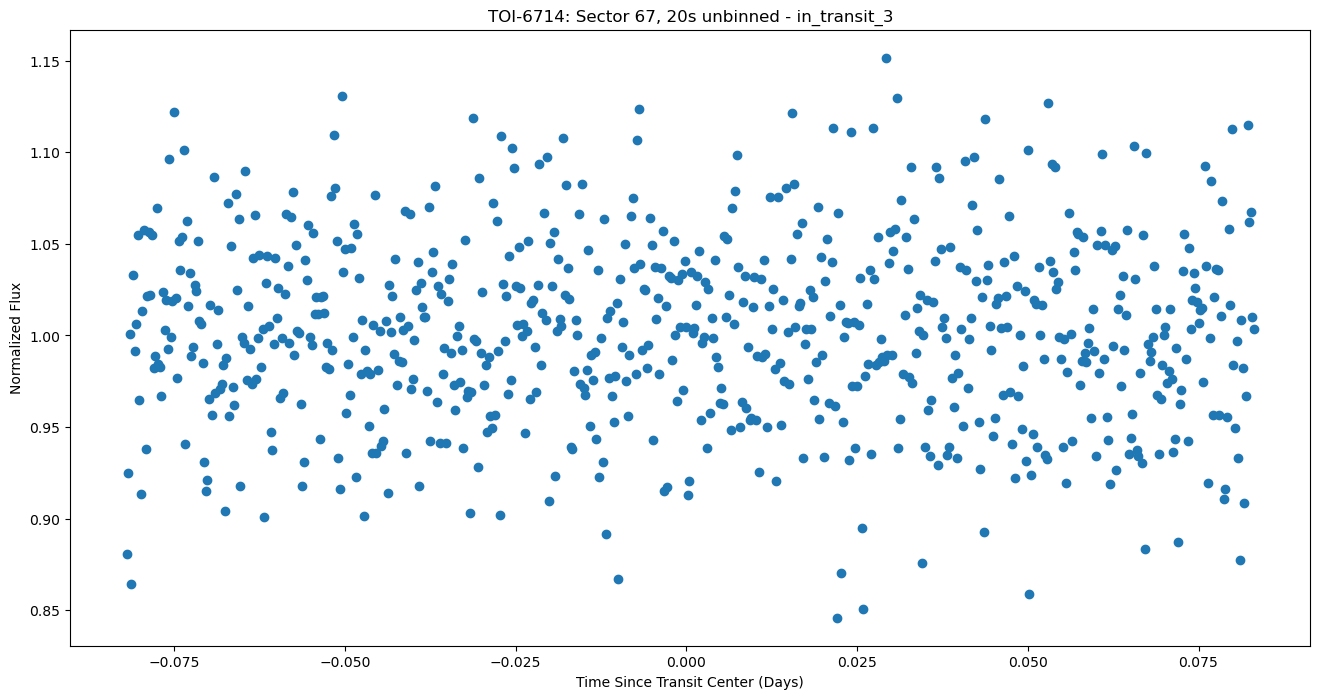

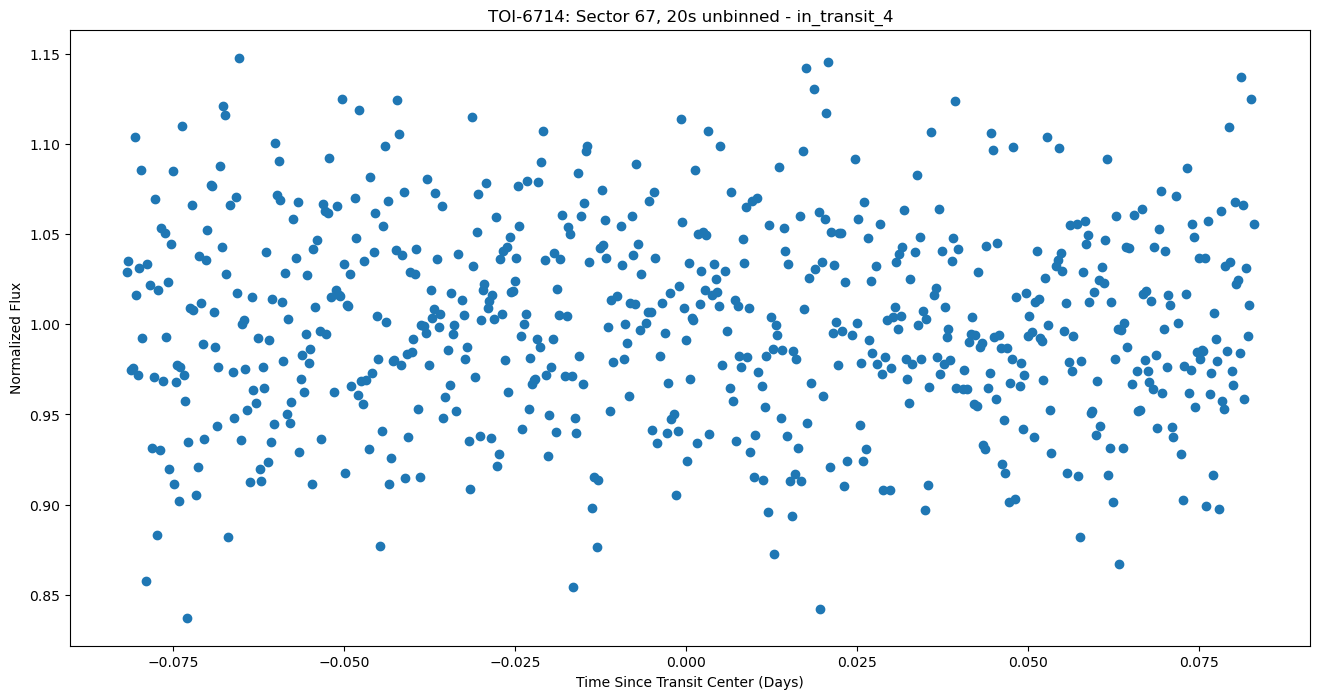

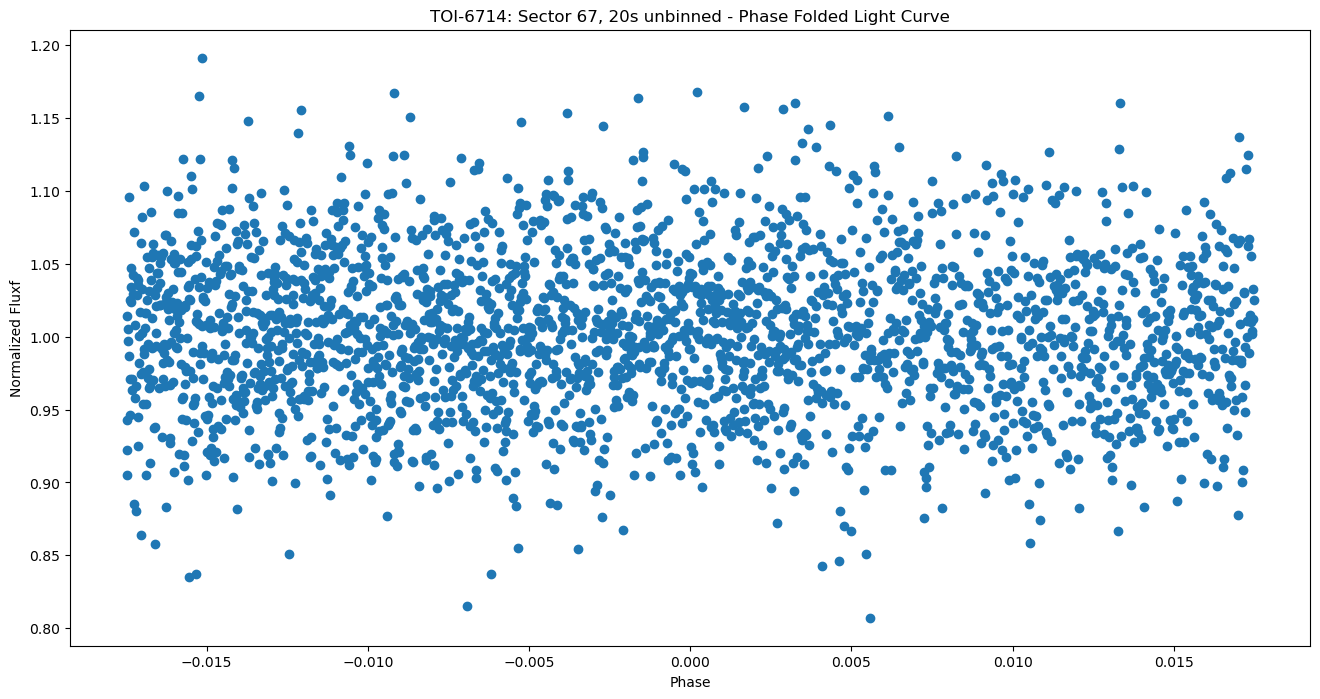

In [16]:
create_light_curve(f'TIC {ticid}', 'SPOC', 67, auto = True, exposure=20, targetname = f'TOI-{toi}', keep_secondary_eclipse=False,
                   ecosw = 0.1335, t14s = 0.1025, save = True, plot = True, planet='b', published = False, qualityFlag = False, #omit_transit_index=[2, 5],
                   outputfiles='slimflat', outputdir = outpath)

## Generating scripts to run the fit

After collecting all lightcurves, change the exptimes array in the following cell and then run it to generate the final files. By default, a dilution term will be fit for the TESS bands. After running the initial fit, if this is consistent with zero, it can be removed from the fit.

In [21]:
# outpath = f'/Users/jack/Research/meep2/toi{toi}/'
exptimes = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1] # exposure times in minutes of included lightcurves (by index/chronological order)
# tess_lcs = [1, 1, 1, 1] # booleans for whether or not each lightcurve is from TESS
generate_pro_file(toi, ticid, exptimes, tess_lcs=tess_lcs, outpath=outpath)
generate_SLURM_file(toi, outpath=outpath)